# Importing dependencies and setting device

In [3]:
import os
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt

import utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Dataset Collection

## Assignee: 
+ Wen Hao: Build scraper module to gather images of faces
+ Gin, Xiaoxin: Data cleaning. Remove images with inaccuracy label manually.

## Description:

We have chosen to gather our images from Google Image search, by searching for faces with the specified emotion, e.g. `"happy man face"`. For example, the raw images obtained using the search keyword "happy man face" would have the true labels `"happy"` and `"man"`. Adding the word `"face"` to the search term was to reduce the amount of images that might not have any face. This would form the raw dataset of our project.

Collection of data was done via Selenium, a powerful tool for performing browser automation. It is used to automate the scraping from Google Images using the chromedriver. 

The steps for scraping the images are as follows:
1. Open a **headless** browser and navigate to "https://www.google.com/search?q={search_term}&tbm=isch&ijn=0"
  - The parameter `tbm=isch` specifies that this is an image search
  - The parameter `q={search_term}` is the term to search for
2. Keep scrolling down until all results are loaded in page
3. Loop through each image result to get its URL with full resolution (not thumbnail)
4. Save the URL into a json file to be used by another job to download later

The above steps were repeated for all 14 search terms (7 emotions and 2 genders). There is also about a 3 seconds wait between each image in the loop as there is a need to wait for the UI to load to get the full resolution image. Hence, the challenge that we've met while trying to run this locally (on our Macbooks) is that this takes quite a significant amount of time if we run this sequentially one by one on our own laptop.

The next approach to speed this up was to distribute this image search, to run all 14 searches in parallel. To do this, we build a docker container with the scraper and its dependencies built in and build an Airflow DAG (directed acyclic graph) run this on an instance of Airflow, with the search term as a parameter. 

However, the next challenge we found was that Selenium WebDriver/Chromedriver works very differently when running on a Linux based container, oftenly throwing the cryptic error `Selenium::WebDriver::Error::InvalidSessionIdError: invalid session id`. In Linux operating systems there is a shared memory space called `/dev/shm`. Any Linux process can create a partition within `/dev/shm` if the process wants to share memory with another process. This is often done to improve performance of similar processes. The shared memory space is often used by web browsers such as chrome when they’re being orchestrated by a selenium web driver. However, this shared memory space does not scale with device/server memory by default. The solution we used was to mount memory to the path `/dev/shm`. But there is a limitation where the shared memory is limited to half of the system's memory.

While trying to run a single search, I also realised that the WebDriver session seems to only be active for about 30 minutes and beyond that, most containers will start having session timeout errors whie trying to retrieve the image elements.

Hence, we implemented a way to save progress at periodic checkpoints and resume the search from the index that it failed. With this, the overall solution was a brute force solution where we just increase the CPU and memory limit to the maximum possible and keep running it until we have saved all our results. The only caveat is that the image result is not static and the number of results we get is always changing, hence resuming from where we fail from a different search might end up having a slightly different set of results but it not very significant in this case.

<br>

## Airflow Screenshots

Below are the records of the total runs we have from the Airflow UI.

![scrape-man](images/scrape-man.png)

![scrape-woman](images/scrape-woman.png)


<br>

## Resource Monitoring

We have also setup grafana to monitor the resource usage:

![monitor](images/monitor.png)

## Conclusion

From the above chart, we can see that the amount of resources used was linearly increasing as times go on until a point and drops back down to 0. This suggest that there is a possible memory leakage somewhere within the implementation of Selenium WebDriver/Chromedriver. As time was limited, we kind of resolve this by adding checkpoints and brute forcing it by providing more compute resources for it to run to completion. 

Selenium might not have been the best tool for this scraping and we can explore other tools in the future.

### Scraper Demo 

The next cell we will run this scraper in dev mode which will only scrape the first 20 images to show how it works.

In [1]:
!python scraper.py -h

usage: scraper.py [-h] [-s S] [-o O] [-r R] [-d D]

optional arguments:
  -h, --help  show this help message and exit
  -s S        search term to scrape images from
  -o O        output root directory
  -r R        index to resume from
  -d D        whether to run in dev mode


In [2]:
!python scraper.py -s "sad man face" -d true

[2021-11-18 00:38:33,055] [INFO] - Search term: sad man face
[2021-11-18 00:38:34,587] [INFO] - Scrolling down ..
[2021-11-18 00:38:57,003] [INFO] - Reached the end ..
[2021-11-18 00:38:57,269] [INFO] - Total results found: 731
[2021-11-18 00:38:57,269] [INFO] - is_retry: False
[2021-11-18 00:38:57,269] [INFO] - dev: True
search_term=sad man face | is_retry=False : 100%|█| 20/20 [01:08<00:00,  3.41s/i
[2021-11-18 00:40:05,501] [INFO] - Total image URLs extracted in first pass: 20


# Data Pre-processing

## Assignee: Wen Hao

## Description:

This is to pre-process the images gathered. The gathered images from the Google Image search comes in all shape and sizes hence it is necessary to process them before they are reading to be used as inputs to train the neural network.

Below are the preprocessing steps applied to all images in order:
1. Convert image to grayscale
2. Use OpenCV python library to detect faces in the image using Haar feature-based cascade classifier
3. Crop the detected faces along the guiding box coordinates
4. Resize image to 128x128 pixels
5. Save the final output

Similarly, we built the preprocessor into a container with a script callable from the terminal and takes arguments and ran this in an Airflow together with the download job.

![scrape-man](images/download-preprocess.png)

In [4]:
!python download.py -s "sad man face"
!python preprocessor.py -s "sad man face"

[2021-11-18 00:57:38,131] [INFO] - Search term: sad man face
search_term=sad man face : 100%|████████████████| 20/20 [00:05<00:00,  3.40it/s]
[2021-11-18 00:57:44,576] [INFO] - Search term: sad man face
search_term=sad man face: 100%|█████████████████| 20/20 [00:02<00:00,  8.80it/s]


# Data Exploration
Assignee: Gin, Xiaoxin

In [72]:
IMAGE_FOLDER = # replace it with your own path

totalImages = {}
for subfolder in os.listdir(IMAGE_FOLDER):
    dir = IMAGE_FOLDER + '/' + subfolder
    if os.path.isdir(dir):
        totalImages[subfolder] = len(os.listdir(dir))

pd.DataFrame(totalImages.items(), columns = ['category', '# of sample'])

,category,# of sample
0,neutral man face,241
1,sad woman face,848
2,angry woman face,753
3,disgusted woman face,746
4,happy man face,192
5,surprised woman face,851
6,sad man face,359
7,scared man face,394
8,angry man face,331
9,disgusted man face,514


In [73]:
print(sum(totalImages.values()), "files in total.")

7981 files in total.


# Dataset Augmentation and Preparation 

In this step, we will prepare the collected data as a dataset that is ready to be used for training with some augmentation (random rotation, random horizontal flip, resizing and output as tensor).

In [10]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation']
Train Classes - ['happy', 'scared', 'surprised', 'neutral', 'angry', 'disgusted', 'sad']
Validation Classes - ['happy', 'scared', 'surprised', 'neutral', 'angry', 'disgusted', 'sad']


In [11]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.Resize((128,128)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [12]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', train_tfms)

In [13]:
# PyTorch data loaders
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

Feature batch shape: torch.Size([100, 1, 128, 128])
Labels batch shape: torch.Size([100])


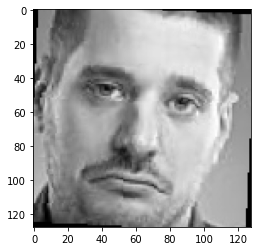

Label: 4


In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 128, 128])


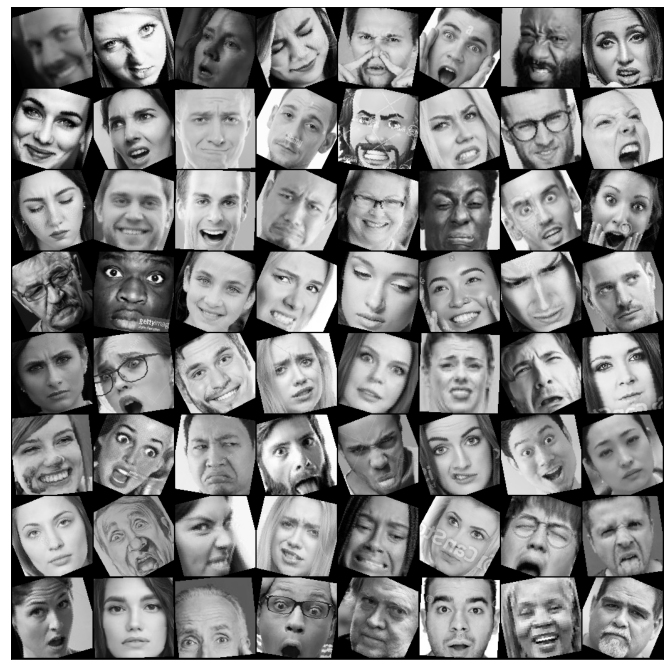

In [16]:
show_batch(train_dl)

# Utilities for later steps
 
 - Calculating the mean and std of the dataset for normalization
 - Function to evaluate the network on input dataset

In [17]:
mean = 0.0
meansq = 0.0
count = 0

for index, (data, _) in enumerate(train_dl):
    mean = data.sum()
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)
print("mean: " + str(total_mean))
print("std: " + str(total_std))

mean: tensor(0.0026)
std: tensor(0.5862)


In [18]:
def eval_on_dataset_loader(model, dataset_loader):

    running_error=0
    num_batches=0

    for minibatch_data, minibatch_label in dataset_loader:
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # normalize the minibatch
        inputs = (minibatch_data - total_mean) / total_std
        
        if isinstance(model, three_layer_net):
            inputs = inputs.view(-1, 128*128)

        # feed it to the network
        scores=model(inputs) 

        # compute the error made on this batch
        error = utils.get_error(scores, minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print('error rate on dataset =', total_error*100 ,'percent')

# Model Development, Improvement & Evaluation

# 1. Multi Layer Perceptron (MLP)

The first attempt was to implement the MLP first as a baseline.

In [27]:
# PyTorch data loaders
batch_size = 200
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

## Define the three layer net class

In [28]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=True  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=True  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=True  )        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores
    

# Build the net with the following size:

In [29]:
mlp = three_layer_net(128*128, 500, 500, 7)
print(mlp)
utils.display_num_param(mlp)

three_layer_net(
  (layer1): Linear(in_features=16384, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=500, bias=True)
  (layer3): Linear(in_features=500, out_features=7, bias=True)
)
There are 8446507 (8.45 million) parameters in this neural network


# Send the weights of the networks to the GPU

In [30]:
mlp = mlp.to(device)

# Choose the criterion and optimizer

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(mlp.parameters() , lr=0.01 )

# Do 200 passes through the training set

In [34]:
start=time.time()

for epoch in range(200):
    
    running_loss=0
    running_error=0
    num_batches=0
 
    for minibatch_data, minibatch_label in train_dl:
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(-1, 128*128)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores = mlp(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss = criterion(scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', 0.01  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_dataset_loader(mlp, valid_dl)
    print(' ')
    

epoch= 0 	 time= 2.1031365394592285 min 	 lr= 0.01 	 loss= 1.8689881324768067 	 error= 75.36000061035156 percent
error rate on dataset = 75.9646455446879 percent
 
epoch= 1 	 time= 4.9138712882995605 min 	 lr= 0.01 	 loss= 1.8717430067062377 	 error= 74.94000101089478 percent
error rate on dataset = 72.38888740539551 percent
 
epoch= 2 	 time= 7.690876722335815 min 	 lr= 0.01 	 loss= 1.8630168914794922 	 error= 74.8800003528595 percent
error rate on dataset = 72.31818040211996 percent
 
epoch= 3 	 time= 10.392363548278809 min 	 lr= 0.01 	 loss= 1.8705710887908935 	 error= 75.84000039100647 percent
error rate on dataset = 79.97979720433554 percent
 
epoch= 4 	 time= 13.13011121749878 min 	 lr= 0.01 	 loss= 1.866063690185547 	 error= 75.42000079154968 percent
error rate on dataset = 78.96464467048645 percent
 
epoch= 5 	 time= 15.721792459487915 min 	 lr= 0.01 	 loss= 1.8589179134368896 	 error= 74.46000027656555 percent
error rate on dataset = 82.23737279574075 percent
 
epoch= 6 	 time

# 2. VGG Neural Networks

Over here, we train a simple VGG, a Very Deep Convolutional Networks for Large-Scale Image Recognition which was propsed by Visual Geometry Group in 2014.


In [ ]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         1 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(1,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

In [ ]:
vgg = VGG_convnet()
print(vgg)
utils.display_num_param(vgg)

VGG_convnet(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(i

In [ ]:
vgg = vgg.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
my_lr=0.25  

In [ ]:
start=time.time()

for epoch in range(1,200):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    for minibatch_data, minibatch_label in train_dl:
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(-1, 1, 32, 32)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_dataset_loader(vgg, train_dl)
    print(' ')

epoch= 1 	 time= 0.16052822271982828 min 	 lr= 0.25 	 loss= 2.019545246645347 	 error= 82.12371173593186 percent
error rate on test set = 81.45454525947571 percent
 
epoch= 2 	 time= 0.33595306078592935 min 	 lr= 0.25 	 loss= 1.9555120480429267 	 error= 82.08247478475276 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 3 	 time= 0.5116730650266011 min 	 lr= 0.25 	 loss= 1.9491242944579763 	 error= 82.30927869216683 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 4 	 time= 0.6883858442306519 min 	 lr= 0.25 	 loss= 1.9464216392064833 	 error= 81.62886629399566 percent
error rate on test set = 81.27272725105286 percent
 
epoch= 5 	 time= 0.8643346468607584 min 	 lr= 0.25 	 loss= 1.9442517732836537 	 error= 81.29896933270484 percent
error rate on test set = 87.09090948104858 percent
 
epoch= 6 	 time= 1.036573048432668 min 	 lr= 0.25 	 loss= 1.9432222646536286 	 error= 81.83505227885294 percent
error rate on test set = 81.27272725105286 percent
 
epoc

# VGG -- nn.MaxPool2d(4 x 4)
The attempted improvement done over here is to increase the size of the average pooling layers from 2x2 to 4x4. This was done for multiple reasons.

We do not wish to resize the input layer of 1x128x128 first because this image classification tasks deals with facial expressions and facial features which are detailed and may contain useful features for each small pixel. However, due to the size of the input layer, it results in a number of parameters in the neural network. This may result in overfitting.

Hence, to reduce the number of parameters, while seeking to retain the information captured at fine-grain pixel level, we attemp to increase the size of the average pooling layers.

In [ ]:
class VGG_convnet_px128(nn.Module):

    def __init__(self):
        super(VGG_convnet, self).__init__()

        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

    def forward(self, x):
        # block 1:         1 x 128 x 128 --> 64 x 64 x 64
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 64 x 64 --> 128 x 16 x 16
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 16 x 16 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)

        return x
    
'''
utils.display_num_param(net)

VGG_convnet_px128(
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  There are 27539402 (27.54 million) parameters in this neural network
)
'''

'''
See log/vgg_px128.txt for the full output.
 
epoch= 197 	 time= 13.116444532076518 min 	 lr= 0.03125 	 loss= 0.1217539941642395 	 error= 4.123713613785419 percent
error rate on test set = 53.06818268515847 percent
 
epoch= 198 	 time= 13.181400994459787 min 	 lr= 0.03125 	 loss= 0.10981417798734817 	 error= 3.4639196912037957 percent
error rate on test set = 49.53409162434665 percent
 
epoch= 199 	 time= 13.245910755793254 min 	 lr= 0.03125 	 loss= 0.10294757859262917 	 error= 3.216496878063556 percent
error rate on test set = 50.806818767027416 percent
'''


# Dropout
We find that the error rate on the train set is much higher than the test set.

In order to combat overfitting in the network, we try inserting Dropout layers after convolutional layers.

In [ ]:
class VGG_convnet_dropout(nn.Module):

    def __init__(self):
        super(VGG_convnet, self).__init__()

        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(4, 4)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)

    def forward(self, x):
        # block 1:         1 x 128 x 128 --> 64 x 32 x 32
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 32 x 32 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        # block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)

        return x

'''
VGG_convnet(     
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.5, inplace=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
)
There are 27539402 (27.54 million) parameters in this neural network
'''

'''
See log/vgg_dropout.txt for the full output.
 
epoch= 196 	 time= 13.345274138450623 min 	 lr= 0.03125 	 loss= 0.5204616894119793 	 error= 19.60824961514817 percent
error rate on test set = 49.590908939188175 percent
 
epoch= 197 	 time= 13.412516383330027 min 	 lr= 0.03125 	 loss= 0.5394029445254925 	 error= 20.49484738369578 percent
error rate on test set = 50.23863857442682 percent
 
epoch= 198 	 time= 13.479526805877686 min 	 lr= 0.03125 	 loss= 0.5349615907546171 	 error= 19.793816694279307 percent
error rate on test set = 50.943182273344554 percent
 
epoch= 199 	 time= 13.546925719579061 min 	 lr= 0.03125 	 loss= 0.5200335079247189 	 error= 19.31958985082882 percent
error rate on test set = 50.69318251176313 percent
'''


# Choice of Optimizer

We try three optimizers:
+ SGD
+ SGD + Momentum
+ Adam

For fare comparision, we use the default values of learning rate, beta1 and beta2 in pytorch.


Our observations:

+ Convergence. Adaptive optimizers such as Adam give fatser convergence than SGD and Momentum SGD, but it may get stuck in a local minima somehow and provides poor generalization

+ Global minima. SGD+momentum can achieve to find a global minima, but it relies on robust initializations and it might take longer than Adam to converge



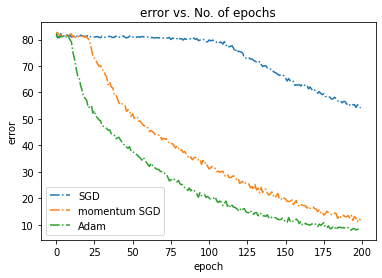

In [7]:
utils.plot_optimizers('error')

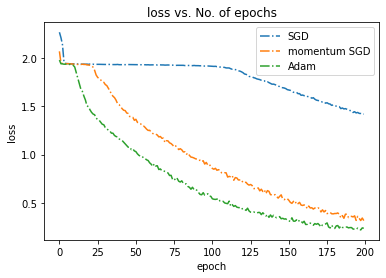

In [8]:
 utils.plot_optimizers('loss')

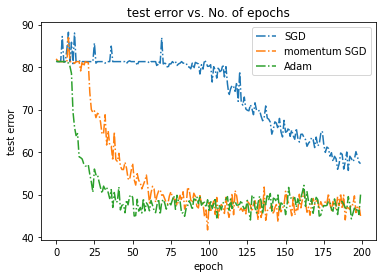

In [9]:
import utils
utils.plot_optimizers('test error')

## SGD

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

'''
See log/optimizer_sgd.txt for the full output.

epoch= 197 	 time= 16.640492721398672 min 	 loss= 1.4266390739027988 	 error= 55.340207421902534 percent
error rate on test set = 58.886363831433385 percent
epoch= 198 	 time= 16.727175052960714 min 	 loss= 1.4200772022463612 	 error= 54.90721771397542 percent
error rate on test set = 57.602274959737606 percent
epoch= 199 	 time= 16.81212347348531 min 	 loss= 1.4205077726816393 	 error= 54.08247543364456 percent
error rate on test set = 57.27272792295977 percent
'''

## SGD + Momentum

In [ ]:
# Momentum SGD
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

'''
See log/optimizer_sgd_momentum.txt for the full output.

epoch= 197 	 time= 17.621728281180065 min 	 loss= 0.31581137352383015 	 error= 11.175260347189363 percent
error rate on test set = 47.12500084530223 percent
epoch= 198 	 time= 17.705276453495024 min 	 loss= 0.3418008195063503 	 error= 12.350518064400584 percent
error rate on test set = 47.30681831186468 percent
epoch= 199 	 time= 17.794385369618734 min 	 loss= 0.31510837414522763 	 error= 11.711342617408517 percent
error rate on test set = 44.95454647324302 percent
'''

## Adam

In [ ]:
# Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

'''
See log/optimizer_adam.txt for the full output.

epoch= 197 	 time= 14.945561536153157 min 	 lr= 0.0001 	 loss= 0.21837057687879838 	 error= 8.247424523854994 percent
error rate on test set = 46.76136482845653 percent
epoch= 198 	 time= 15.016908542315166 min 	 lr= 0.0001 	 loss= 0.239205996246682 	 error= 8.536084964103305 percent
error rate on test set = 45.306819677352905 percent
epoch= 199 	 time= 15.092707566420238 min 	 lr= 0.0001 	 loss= 0.23558733973306478 	 error= 8.247424953991604 percent
error rate on test set = 49.977273832667954 percent
'''

# Validate Model Using Standard Dataset
We train our model a public dataset [fer-2013](https://www.kaggle.com/msambare/fer2013).

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

In [ ]:
'''
See log/vgg_fer_2013.txt for the full output.

epoch= 197 	 time= 70.96889228026072 min 	 loss= 0.1701572123931154 	 error= 5.754978128101515 percent
error rate on test set = 37.50396979351838 percent
epoch= 198 	 time= 71.32047909498215 min 	 loss= 0.1636838308264218 	 error= 5.540871723838475 percent
error rate on test set = 37.52678744494915 percent
epoch= 199 	 time= 71.68298303683599 min 	 loss= 0.1676228751918382 	 error= 5.481741283250892 percent
error rate on test set = 38.29861258467038 percent
'''

# 3. LeNet5
Over here, we train a simple LeNet5 Architecture that was proposed by LeCun and team in 1998. It has a total of two sets of convolution layers with a combination of subsampling, followed by two fully connected layers.

 

1.   The first layer is the input layer with feature map size 1x128x128.
2.   Then, we have the convolution layer with 50 filters of size 3x3 and stride 1. The activation function used at this layer is ReLU. The output feature map is 50x128x128.
3.   Next, we have an max pooling layer with filter size 2x2 and stride 1. The resulting feature map is 50x64x64.
4.   Then, we have a second convolution layer with 100 filters of size 3x3 and stride 1. The activation function used at this layer is ReLU. The output feature map is 100x64x64.
5.   Next, we have an max pooling layer with filter size 2x2 and stride 1. The resulting feature map is 100x32x32.
6.   Then, we have a fully connected layer with 100 neurons that results in the output of 100 values. The activation function used is also ReLU.
7.   Finally, we have a fully connected layer with 7 neurons to output 7 values that will represent the class that a data point would belong to.

In [4]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 64 x 64
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 64 x 64 -->    100 x 32 x 32
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 32 x 32 = 102,400 -->  100
        self.linear1 = nn.Linear(102400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        self.x1 = self.conv1(x)
        self.x2 = torch.relu(self.x1)
        self.x3 = self.pool1(self.x2)
        self.x4 = self.conv2(self.x3)
        self.x5 = torch.relu(self.x4)
        self.x6 = self.pool2(self.x5)
        self.x7 = self.x6.view(-1, 102400)
        self.x8 = self.linear1(self.x7)
        self.x9 = torch.relu(self.x8)
        self.out = self.linear2(self.x9)
    
        return self.out

    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7, self.x8, self.x9, self.out

The number of trainable parameters of this architecture is approximately 10.29 million.

In [5]:
lenet5 = LeNet5_convnet()
print(lenet5)
utils.display_num_param(lenet5)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=102400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 10286407 (10.29 million) parameters in this neural network


Over here, we are doing 200 passes through the training set and dividing the learning rate by 1.5 every 10 epochs to decay it.

In [6]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
device = torch.device('cuda')
net = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = lenet5(train_inputs) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    eval_on_dataset_loader(lenet5, valid_dl)
    
#     valid_running_error=0
#     valid_num_batches=0

#     for valid_minibatch_data, valid_minibatch_label in valid_dl:

#         valid_minibatch_data = valid_minibatch_data.to(device)
#         valid_minibatch_label = valid_minibatch_label.to(device)
        
#         valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

#         valid_scores = net(valid_inputs) 

#         valid_error = utils.get_error(valid_scores , valid_minibatch_label)

#         valid_running_error += valid_error.item()

#         valid_num_batches+=1


#     valid_total_error = valid_running_error / valid_num_batches
#     print('error rate on test set =', valid_total_error*100 , 'percent')
#     print(' ')

epoch= 1 	 time= 6.661961348851522 min 	 lr= 0.25 	 loss= 1.9702238035202027 	 error= 82.66000080108643 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 2 	 time= 7.951790396372477 min 	 lr= 0.25 	 loss= 1.932634859085083 	 error= 80.70000076293945 percent
error rate on test set = 81.16161823272705 percent
 
epoch= 3 	 time= 8.179031737645467 min 	 lr= 0.25 	 loss= 1.9336142015457154 	 error= 80.82000064849854 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 4 	 time= 8.408081058661143 min 	 lr= 0.25 	 loss= 1.9312482738494874 	 error= 80.760000705719 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 5 	 time= 8.637881529331207 min 	 lr= 0.25 	 loss= 1.9255378866195678 	 error= 79.20000052452087 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 6 	 time= 8.868585646152496 min 	 lr= 0.25 	 loss= 1.9193805265426636 	 error= 79.51999998092651 percent
error rate on test set = 79.78282968203226 percent
 
epoch= 7 	 time= 

In [9]:
torch.save(lenet5.state_dict(), 'trained_models/emotion/lenet5_128_rotate.pt')

## LeNet5 -- nn.MaxPool2d(4 x 4)

The attempted improvement done over here is to increase the size of the max pooling layers from 2x2 to 4x4. This was done for multiple reasons.

We do not wish to resize the input layer of 1x128x128 first because this image classification tasks deals with facial expressions and facial features which are detailed and may contain useful features for each small pixel. However, due to the size of the input layer, it results in a number of parameters in the neural network. This may result in overfitting.

Hence, to reduce the number of parameters, while seeking to retain the information captured at fine-grain pixel level, we attempt to increase the size of the max pooling layers.

In [48]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   128 x 128  -->    50 x 128 x 128 
        self.conv1 = nn.Conv2d(1,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 128 x 128 -->    50 x 32 x 32
        self.pool1  = nn.MaxPool2d(4,4)
        
        # CL2:   50 x 32 x 32  -->    100 x 32 x 32 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 32 x 32 -->    100 x 8 x 8
        self.pool2 = nn.MaxPool2d(4,4)
        
        # LL1:   100 x 8 x 8 = 6400 -->  100
        self.linear1 = nn.Linear(6400, 100)
        
        # LL2:   100  -->  7
        self.linear2 = nn.Linear(100, 7)


    def forward(self, x):

        self.x1 = self.conv1(x)
        self.x2 = torch.relu(self.x1)
        self.x3 = self.pool1(self.x2)
        self.x4 = self.conv2(self.x3)
        self.x5 = torch.relu(self.x4)
        self.x6 = self.pool2(self.x5)
        self.x7 = self.x6.view(-1, 6400)
        self.x8 = self.linear1(self.x7)
        self.x9 = torch.relu(self.x8)
        self.out = self.linear2(self.x9)
    
        return self.out

    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.x7, self.x8, self.x9, self.out

In [49]:
lenet5_v2 = LeNet5_convnet()
print(lenet5_v2)
utils.display_num_param(lenet5_v2)

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 686407 (0.69 million) parameters in this neural network


In [50]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
lenet5_v2 = net.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%10:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = lenet5_v2(train_inputs) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    eval_on_dataset_loader(lenet5_v2, valid_dl)
    
#     valid_running_error=0
#     valid_num_batches=0

#     for valid_minibatch_data, valid_minibatch_label in valid_dl:

#         valid_minibatch_data = valid_minibatch_data.to(device)
#         valid_minibatch_label = valid_minibatch_label.to(device)
        
#         valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

#         valid_scores = net(valid_inputs) 

#         valid_error = utils.get_error(valid_scores , valid_minibatch_label)

#         valid_running_error += valid_error.item()

#         valid_num_batches+=1


#     valid_total_error = valid_running_error / valid_num_batches
#     print('error rate on test set =', valid_total_error*100 , 'percent')
#     print(' ')

epoch= 1 	 time= 0.15357844432195028 min 	 lr= 0.25 	 loss= 1.937640199661255 	 error= 81.16000056266785 percent
error rate on test set = 82.5000007947286 percent
 
epoch= 2 	 time= 0.3268059770266215 min 	 lr= 0.25 	 loss= 1.930358691215515 	 error= 81.42000007629395 percent
error rate on test set = 83.21212132771811 percent
 
epoch= 3 	 time= 0.4992769757906596 min 	 lr= 0.25 	 loss= 1.9228908109664917 	 error= 79.90000081062317 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 4 	 time= 0.6723734458287557 min 	 lr= 0.25 	 loss= 1.913659052848816 	 error= 78.62000012397766 percent
error rate on test set = 78.78787914911905 percent
 
epoch= 5 	 time= 0.8460733413696289 min 	 lr= 0.25 	 loss= 1.9360142374038696 	 error= 80.5 percent
error rate on test set = 82.16666777928671 percent
 
epoch= 6 	 time= 1.0133268713951111 min 	 lr= 0.25 	 loss= 1.9022597932815553 	 error= 78.84000039100647 percent
error rate on test set = 74.80808099110922 percent
 
epoch= 7 	 time= 1.18

In [51]:
torch.save(lenet5_v2.state_dict(), 'trained_models/emotion/lenet5_128_rotate_4x4.pt')

## Slow Down Decaying of LR
In the previous rounds, we notice that the LR decayed too quickly. Hence, the error rate on test set stagnant at an early stage. Hence, over here, we decrease learning rate only after 50 epoch instead of 10 epoch.

In [52]:
lenet5_v3 = LeNet5_convnet()
print(lenet5_v3)
utils.display_num_param(lenet5_v3)

criterion = nn.CrossEntropyLoss()
my_lr = 0.25
lenet5_v3 = lenet5_v3.to(device)
# mean = mean.to(device)
# std = std.to(device)

start = time.time()

for epoch in range(1,200):
    
    if not epoch%50:
        my_lr = my_lr / 1.5
        
    optimizer = torch.optim.SGD( net.parameters() , lr=my_lr )
    
    #################
    # TRAINING DATA #
    #################
        
    train_running_loss = 0
    train_running_error = 0
    train_num_batches = 0
    
    for train_minibatch_data, train_minibatch_label in train_dl:
        
        # FORWARD AND BACKWARD PASS
    
        optimizer.zero_grad()
        
        train_minibatch_data = train_minibatch_data.to(device)
        train_minibatch_label = train_minibatch_label.to(device)
        
        train_inputs = train_minibatch_data.view(-1, 1, 128, 128) # (train_minibatch_data - mean) / std
        
        train_inputs.requires_grad_()

        train_scores = lenet5_v3(train_inputs) 

        train_loss = criterion(train_scores , train_minibatch_label) 
          
        train_loss.backward()
        
        optimizer.step()
        
        # COMPUTE STATS
        
        train_running_loss += train_loss.detach().item()
        
        train_error = utils.get_error(train_scores.detach() , train_minibatch_label)
        train_running_error += train_error.item()
        
        train_num_batches += 1        
    
    
    # AVERAGE STATS THEN DISPLAY
    train_total_loss = train_running_loss / train_num_batches
    train_total_error = train_running_error / train_num_batches
    train_elapsed = (time.time()-start) / 60
    
    print(
        'epoch=', epoch,
        '\t time=', train_elapsed,
        'min', 
        '\t lr=', my_lr ,
        '\t loss=', train_total_loss, 
        '\t error=', train_total_error*100,
        'percent'
    )
    
    ###################
    # VALIDATION DATA #
    ###################
    
    eval_on_dataset_loader(lenet5_v3, valid_dl)
    
#     valid_running_error=0
#     valid_num_batches=0

#     for valid_minibatch_data, valid_minibatch_label in valid_dl:

#         valid_minibatch_data = valid_minibatch_data.to(device)
#         valid_minibatch_label = valid_minibatch_label.to(device)
        
#         valid_inputs = valid_minibatch_data.view(-1, 1, 128, 128) # (valid_minibatch_data - mean) / std    # ONLY CHANGE IS HERE!

#         valid_scores = net(valid_inputs) 

#         valid_error = utils.get_error(valid_scores , valid_minibatch_label)

#         valid_running_error += valid_error.item()

#         valid_num_batches+=1


#     valid_total_error = valid_running_error / valid_num_batches
#     print('error rate on test set =', valid_total_error*100 , 'percent')
#     print(' ')

LeNet5_convnet(
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=6400, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=7, bias=True)
)
There are 686407 (0.69 million) parameters in this neural network
epoch= 1 	 time= 0.15087319612503053 min 	 lr= 0.25 	 loss= 1.934810633659363 	 error= 81.92000102996826 percent
error rate on test set = 82.8333338101705 percent
 
epoch= 2 	 time= 0.31600950558980306 min 	 lr= 0.25 	 loss= 1.9305361032485961 	 error= 81.12000036239624 percent
error rate on test set = 79.88888820012411 percent
 
epoch= 3 	 time= 0.4836360772450765 min 	 lr= 0.25 	 loss= 1.9260465669631959 	 error= 80.28000068664551 percent
error rate on 

In [53]:
torch.save(lenet5_v3.state_dict(), 'trained_models/emotion/lenet5_128_rotate_4x4_reducedLR.pt')

## Load Model Weights and Predict

In [10]:
# Load model and weights
loaded_net=LeNet5_convnet()
loaded_net.load_state_dict(torch.load('trained_models/emotion/lenet5_128_rotate.pt'))
loaded_net.eval()
loaded_net.parameters()

<generator object Module.parameters at 0x7f8e698062d0>

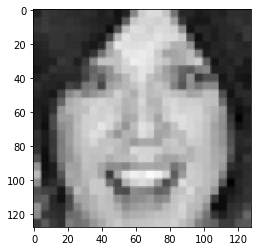

True: 4, Predicted: 1


In [29]:
# choose a picture at random
from random import randint

images, gts = list(iter(valid_dl))[randint(0, 3-1)]

idx=randint(0, images.size()[0]-1)
im = images[idx]
gt = gts[idx]

# diplay the picture
utils.show(im.squeeze(0))

# feed it to the net and display the confidence scores
scores =  loaded_net(im.view(-1, 1, 128, 128)) 
probs = torch.softmax(scores, dim=1)
print(f"True: {gt}, Predicted: {probs.argmax()}")

## Visualisation

### Visualise Training Loss, Training Error, Test Error

In [7]:
def extract(fn):
    loss = []
    error = []
    test_error = []
    with open(fn) as f:
        lines = f.read().splitlines()
    for line in lines:
        if 'epoch=' in line:
            loss.append(float(line.split('loss=')[1].split()[0]))
            error.append(float(line.split('error=')[1].split()[0]))
        elif "error rate on test set =" in line:
            test_error.append(float(line.split("=")[1].split()[0]))

    return loss, error, test_error

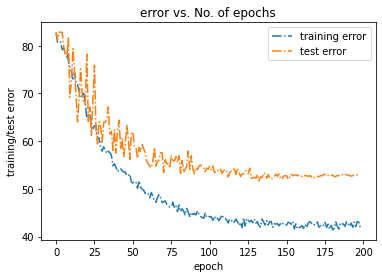

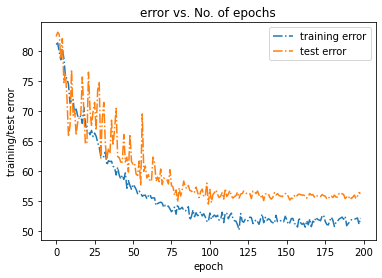

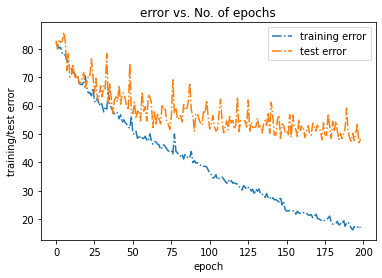

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import os

dir = 'trained_models/emotion'
fns = [
       'lenet5_128_rotate',
       'lenet5_128_rotate_4x4',
       'lenet5_128_rotate_4x4_reducedLR',
]
test_error_dict = {}

for fn in fns:
  loss, error, test_error =  extract(os.path.join(dir, f'{fn}.txt'))
  test_error_dict.update({fn: test_error})

  plt.plot(error, '-.', label='training error')
  plt.plot(test_error, '-.', label='test error')
  plt.xlabel('epoch')
  plt.ylabel('training/test error')
  plt.title('error vs. No. of epochs')
  plt.legend()
  plt.savefig(f"{fn}_train_test_error.jpg", dpi=300)
  plt.figure().clear()

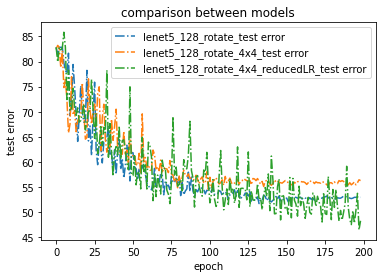

In [9]:
for m_name, test_error in test_error_dict.items():
  plt.plot(test_error, '-.', label=f'{m_name}_test error')
plt.xlabel('epoch')
plt.ylabel('test error')
plt.title('comparison between models')
plt.legend()
plt.savefig(f"comparison_test_error.jpg", dpi=300)

### Visualise filter weights and feature maps in each layer

torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([1, 3, 3]) torch.Size([3, 3])
torch.Size([50, 1, 3, 3])


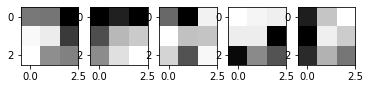

In [55]:
import matplotlib.pyplot as plt

# Visualize conv1 filter
kernels = loaded_net.conv1.weight.detach()
plt.figure()
for idx in range(kernels.size(0))[:5]:
    plt.subplot(151 + idx)
    plt.imshow(kernels[idx].squeeze(0).cpu(), cmap = 'Greys')
    # plt.imshow(kernels[idx].squeeze(), cmap = 'Greys')
    print(kernels[idx].shape, kernels[idx].squeeze().shape)
print(kernels.size())

torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([3, 3]) torch.Size([3, 3])
torch.Size([100, 50, 3, 3])


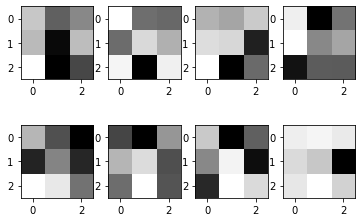

In [57]:
# Visualize conv2 filter
kernels = loaded_net.conv2.weight.detach()
plt.figure()
count = 0
for idx0 in range(kernels.size(0))[:4]:
    for idx1 in range(kernels.size(1))[:2]:
        plt.subplot(241 + count)
        count += 1
        plt.imshow(kernels[idx0][idx1].squeeze().cpu(), cmap = 'Greys')
        print(kernels[idx0][idx1].shape, kernels[idx0][idx1].squeeze().shape)
print(kernels.size())

In [30]:
# Feature maps
fmaps = loaded_net.get_features()
len(fmaps)

10

fmap: 0
fmap: 1
fmap: 2
fmap: 3
fmap: 4
fmap: 5


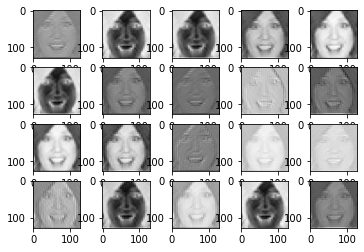

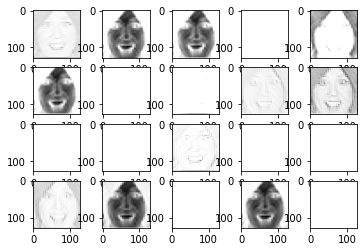

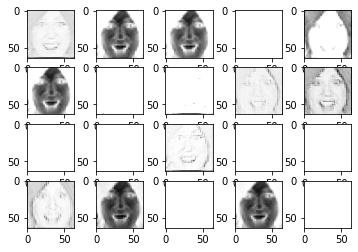

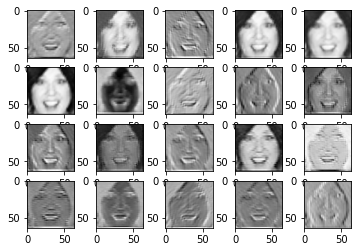

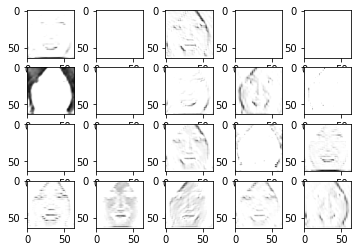

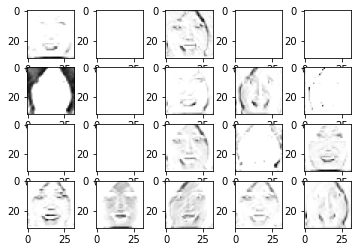

In [43]:
for j in range(len(fmaps))[:6]:
  ## Visualize fmap
  fmap = fmaps[j]
  fmap.squeeze().size(0)

  plt.figure()

  for i in range(fmap.squeeze().size(0))[:20]: # sample 20 from 50 chnnels
      plt.subplot(4, 5, i + 1)
      plt.imshow(fmap.squeeze()[i].detach().numpy(), cmap = 'Greys')

# Model Development, Improvement & Evaluation